
# 🏡 SIT720 — Task 8.2D (HD+)  
**Melbourne Housing Price Prediction — Raw → Clean → EDA → Models → App**

**Design choice:** We **only define the raw dataset path upfront**. Everything else (cleaned CSV, audit JSON, model file, app file) is **created later, at the moment it’s needed**, so this notebook mirrors your workflow: *start with raw data and walk forward.*

**Assignment coverage**  
1) Data acquisition — uses your `dataset_realestate.csv` (≥150 points across 3 suburbs).
2) Preprocessing & EDA — cleaning rules + engineered features + charts with interpretations.
3) Models — ≥3 models, k‑fold CV (MAE, RMSE, R²), fair comparison.
4) Feature importance — model‑agnostic (permutation importance).
5) Deployment — tiny Streamlit app (screenshot for report).


## 0) Setup & Imports — **only RAW_PATH defined here**

In [1]:

import os, re, math, json, warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, cross_validate, cross_val_predict, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from scipy.stats import randint, uniform
import joblib

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 120)

# ✅ Only this path is defined at the start
RAW_PATH = Path("data/dataset_realestate.csv")  # change if your file is elsewhere

print("Working dir:", os.getcwd())
print("RAW dataset path:", RAW_PATH)


Working dir: /Users/nazhimkalam/Documents/Github/MS-Data-Science/SIT720 - Machine Learning/Realestate - D Task
RAW dataset path: data/dataset_realestate.csv



## 1) Load Raw Data & Quick Profile  
We start from the raw CSV, inspect columns, null %, and uniqueness. Include a screenshot/table of `prof` in your report.


In [2]:

df_raw = pd.read_csv(RAW_PATH)

print("Raw shape:", df_raw.shape)

display(df_raw.head())

prof = (
    pd.DataFrame({
        "column": df_raw.columns,
        "dtype": [str(df_raw[c].dtype) for c in df_raw.columns],
        "non_null": [df_raw[c].notna().sum() for c in df_raw.columns],
        "null_%": [100 * df_raw[c].isna().mean() for c in df_raw.columns],
        "n_unique": [df_raw[c].nunique(dropna=True) for c in df_raw.columns],
    })
    .sort_values(["null_%", "column"])
    .reset_index(drop=True)
)

display(prof.head(30))


Raw shape: (225, 326)


,url,title,price/display,description,constructionStatus,channel,propertyType,landSize/display,landSize/displayApp,landSize/displayAppAbbreviated,landSize/unit,landSize/value,address/locality,address/location/latitude,address/location/longitude,address/postCode,address/postcode,address/showAddress,address/state,address/streetAddress,address/subdivisionCode,address/suburb,generalFeatures/bathrooms/label,generalFeatures/bathrooms/type,generalFeatures/bathrooms/value,generalFeatures/bedrooms/label,generalFeatures/bedrooms/type,generalFeatures/bedrooms/value,generalFeatures/parkingSpaces/label,generalFeatures/parkingSpaces/type,generalFeatures/parkingSpaces/value,propertyFeatures/0/features/0,propertyFeatures/0/features/1,propertyFeatures/0/features/2,propertyFeatures/0/features/3,propertyFeatures/0/features/4,propertyFeatures/0/features/5,propertyFeatures/0/features/6,propertyFeatures/0/features/7,propertyFeatures/0/features/8,propertyFeatures/0/features/9,propertyFeatures/0/features/10,propertyFeatures/0/features/11,propertyFeatures/0/features/12,propertyFeatures/0/label,propertyFeatures/0/section,propertyFeatures/1/features/0,propertyFeatures/1/features/1,propertyFeatures/1/features/2,propertyFeatures/1/features/3,propertyFeatures/1/features/4,propertyFeatures/1/features/5,propertyFeatures/1/features/6,propertyFeatures/1/features/7,propertyFeatures/1/features/8,propertyFeatures/1/features/9,propertyFeatures/1/features/10,propertyFeatures/1/features/11,propertyFeatures/1/features/12,propertyFeatures/1/label,...,images/34/name,images/34/resize,images/34/server,images/34/uri,images/34/video,dateSold/display,dateSold/value,status/label,status/type,agency/_links/agencyProfile/href,agency/_links/agencyProfileWebview/href,agency/address/postcode,agency/address/state,agency/address/streetAddress,agency/address/suburb,agency/agencyId,agency/branded,agency/brandingColors/primary,agency/brandingColors/text,agency/email,agency/logo/images/0/name,agency/logo/images/0/server,agency/logo/images/0/uri,agency/logo/images/1/name,agency/logo/images/1/server,agency/logo/images/1/uri,agency/logo/images/2/name,agency/logo/images/2/server,agency/logo/images/2/uri,agency/logo/images/3/name,agency/logo/images/3/server,agency/logo/images/3/uri,agency/logo/links/default,agency/logo/links/hero image,agency/logo/links/large,agency/logo/links/small,agency/name,agency/phoneNumber,agency/website,lister/_links/agentProfile/href,lister/_links/agentProfileWebview/href,lister/agentId,lister/email,lister/id,lister/jobTitle,lister/mainPhoto/name,lister/mainPhoto/server,lister/mainPhoto/uri,lister/mobilePhoneNumber,lister/name,lister/phoneNumber,lister/powerProfile,lister/website,modifiedDate/value,listingId,signature,featured,productDepth,advertising/priceRange,advertising/region
0,NaN,Generational Victorian Grandeur in a Dream Loc...,"$3,710,000",A rare opportunity to step into a generational...,established,sold,house,669 m&sup2;,669 m²,669 m²,m2,669.0,Hawthorn,-37.819717,145.044640,3122,3122,True,Vic,93 Liddiard Street,Vic,Hawthorn,Bathrooms: 1,bathrooms,1,Bedrooms: 4,bedrooms,4,Parking Spaces: 3,parkingSpaces,3.0,Garage: 1,Open Spaces: 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Outdoor Features,outdoor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,13 Sep 2025,2025-09-13,Sold,sold,https://www.realestate.com.au/agency/marshall-...,https://www.realestate.com.au/agency/marshall-...,3122,VIC,801 Glenferrie Road,Hawthorn,ULNKAO,True,#00101f,#ffffff,advertisingteam@marshallwhite.com.au,large,https://i3.au.reastatic.net,/170x32/a0f0afa8beea76b4336ad3c1958befe38f91aa...,default,https://i3.au.reastatic.net,/160x30/a0f0afa8beea76b4336ad3c1958befe38f91aa...,small,https://i3.au.reastatic.net,/114x21/a0f0afa8beea76b4336ad3c1958befe38f91aa...,hero image,https://i3.au.reastatic.net,/1536x800/674be371b9b1c187f5f88861e8cdda81eccc...,/160x30/a0f0afa8beea76b4336ad3c1958befe38f91aa...,/1536x800/674be371b9b1c187f5f88861e8cdda81eccc...,/170x32/a0f0a

,column,dtype,non_null,null_%,n_unique
0,address/locality,object,225,0.0,3
1,address/postCode,int64,225,0.0,3
2,address/postcode,int64,225,0.0,3
3,address/showAddress,bool,225,0.0,1
4,address/state,object,225,0.0,1
5,address/streetAddress,object,225,0.0,200
6,address/subdivisionCode,object,225,0.0,1
7,address/suburb,object,225,0.0,3
8,agency/_links/agencyProfile/href,object,225,0.0,69
9,agency/_links/agencyProfileWebview/href,object,225,0.0,69



## 2) Detect Key Fields (adapts to scraped keys)  
We find candidate columns by name patterns so this notebook works with your schema.


In [3]:

cols = df_raw.columns.tolist()
detect = lambda pat: [c for c in cols if re.search(pat, c, re.I)]

PRICE_COLS     = detect(r"(price/display|priceRange|^price$|sold[_/ ]?price)")
DATE_COLS      = detect(r"(dateSold|listed|modifiedDate|auction.*date)")
AREA_COLS      = detect(r"(land.*size|lot.*size|area)")
BED_COLS       = detect(r"bed(room)?s?.*value|bed(room)?s?$")
BATH_COLS      = detect(r"bath(room)?s?.*value|bath(room)?s?$")
CAR_COLS       = detect(r"(car|parking|garage).*value|(car|parking|garage)$")
LAT_COLS       = detect(r"latitude|lat$")
LON_COLS       = detect(r"longitude|lon|lng$")
TYPE_COLS      = detect(r"(propertyType|type$)")
SUBURB_COLS    = detect(r"(address/suburb|address/locality|suburb)")
POSTCODE_COLS  = detect(r"(address/postcode|address/postCode|postcode|post code)")

print("PRICE_COLS    :", PRICE_COLS[:4])
print("DATE_COLS     :", DATE_COLS[:4])
print("AREA_COLS     :", AREA_COLS[:4])
print("BED_COLS      :", BED_COLS[:4])
print("BATH_COLS     :", BATH_COLS[:4])
print("CAR_COLS      :", CAR_COLS[:4])
print("LAT_COLS      :", LAT_COLS[:4])
print("LON_COLS      :", LON_COLS[:4])
print("TYPE_COLS     :", TYPE_COLS[:4])
print("SUBURB_COLS   :", SUBURB_COLS[:4])
print("POSTCODE_COLS :", POSTCODE_COLS[:4])


PRICE_COLS    : ['price/display', 'advertising/priceRange']
DATE_COLS     : ['dateSold/display', 'dateSold/value', 'modifiedDate/value']
AREA_COLS     : ['landSize/display', 'landSize/displayApp', 'landSize/displayAppAbbreviated', 'landSize/unit']
BED_COLS      : ['generalFeatures/bedrooms/value']
BATH_COLS     : ['generalFeatures/bathrooms/value']
CAR_COLS      : ['generalFeatures/parkingSpaces/value']
LAT_COLS      : ['address/location/latitude']
LON_COLS      : ['address/location/longitude']
TYPE_COLS     : ['propertyType', 'generalFeatures/bathrooms/type', 'generalFeatures/bedrooms/type', 'generalFeatures/parkingSpaces/type']
SUBURB_COLS   : ['address/locality', 'address/suburb', 'agency/address/suburb']
POSTCODE_COLS : ['address/postCode', 'address/postcode', 'agency/address/postcode']



## 3) Helper Parsers  
Convert messy listing text → numeric features. Keep these small and explainable.


In [4]:

def parse_money(val):
    if pd.isna(val): return np.nan
    s = str(val).lower().strip()
    s = re.sub(r'(contact.*|price.*on.*|auction.*|tbd|poa|n/?a|negotiable|offers.*|by negotiation|^-$)', '', s)
    s = s.replace(',', '')
    m = re.findall(r'\$?\s*([\d\.]+)\s*(k|m)?', s)
    if not m:
        digits = re.findall(r'\d+', s)
        return float(''.join(digits)) if digits else np.nan
    nums = []
    for num, unit in m:
        x = float(num)
        if unit == 'k': x *= 1e3
        if unit == 'm': x *= 1e6
        nums.append(x)
    return float(np.mean(nums))

def parse_area(val):
    if pd.isna(val): return np.nan
    s = str(val).lower().strip().replace(',', '')
    s = s.replace('sqm', 'm2').replace('sq m', 'm2').replace('square metres', 'm2')
    m = re.findall(r'([\d\.]+)\s*(m2|m²|ha|acre|acres)?', s)
    if not m:
        digs = re.findall(r'[\d\.]+', s)
        return float(digs[0]) if digs else np.nan
    num, unit = m[0]
    x = float(num)
    if unit == 'ha': x *= 10000.0
    if unit in ('acre','acres'): x *= 4046.8564224
    return x

def to_int(val):
    if pd.isna(val): return np.nan
    m = re.findall(r'\d+', str(val))
    return int(m[0]) if m else np.nan

def to_dt(val):
    try:
        return pd.to_datetime(val, errors='coerce', infer_datetime_format=True, dayfirst=True)
    except Exception:
        return pd.to_datetime(val, errors='coerce')



## 4) Build a Tidy Modeling Table (raw kept intact)  
We consolidate scattered fields into a single DataFrame held in memory (`df_out`).


In [5]:

df = df_raw.copy()

def first_available(series_list):
    base = None
    for s in series_list:
        if s is None: continue
        base = s if base is None else base.where(base.notna(), s)
    return base

# Target
price_series_list = [df[c].apply(parse_money) for c in PRICE_COLS if c in df]
df_out = pd.DataFrame()
df_out["price_target"] = first_available(price_series_list)

# Beds/Baths/Cars
df_out["bedrooms"]   = first_available([df[c].apply(to_int) for c in BED_COLS if c in df])
df_out["bathrooms"]  = first_available([df[c].apply(to_int) for c in BATH_COLS if c in df])
df_out["car_spaces"] = first_available([df[c].apply(to_int) for c in CAR_COLS if c in df])

# Land size
df_out["land_m2"] = first_available([df[c].apply(parse_area) for c in AREA_COLS if c in df])

# Categorical/meta
ptype = df[TYPE_COLS[0]].astype(str) if TYPE_COLS else "Unknown"
suburb= df[SUBURB_COLS[0]].astype(str) if SUBURB_COLS else "Unknown"
pc    = df[POSTCODE_COLS[0]] if POSTCODE_COLS else np.nan
df_out["property_type"] = ptype
df_out["suburb"]        = suburb
df_out["postcode"]      = pc

# Geo & Dates
df_out["lat"] = pd.to_numeric(df[LAT_COLS[0]], errors="coerce") if LAT_COLS else np.nan
df_out["lon"] = pd.to_numeric(df[LON_COLS[0]], errors="coerce") if LON_COLS else np.nan

date_s = first_available([df[c].apply(to_dt) for c in DATE_COLS if c in df])
df_out["sold_date"]  = date_s
df_out["sold_year"]  = df_out["sold_date"].dt.year
df_out["sold_month"] = df_out["sold_date"].dt.month

print("Tidy table shape:", df_out.shape)
display(df_out.head())


Tidy table shape: (225, 13)


,price_target,bedrooms,bathrooms,car_spaces,land_m2,property_type,suburb,postcode,lat,lon,sold_date,sold_year,sold_month
0,3710000.0,4,1,3.0,669.0,house,Hawthorn,3122,-37.819717,145.044640,2025-09-13,2025,9
1,3500000.0,4,2,3.0,613.0,house,Hawthorn,3122,-37.814675,145.025439,2025-09-13,2025,9
2,1210000.0,4,2,2.0,NaN,apartment,Hawthorn,3122,-37.827869,145.034699,2025-09-11,2025,9
3,800000.0,2,1,1.0,NaN,apartment,Hawthorn,3122,-37.825660,145.025419,2025-09-11,2025,9
4,675000.0,2,1,1.0,NaN,apartment,Hawthorn,3122,-37.826548,145.025691,2025-09-11,2025,9



## 5) Feature Engineering  
Add **distance to Melbourne CBD** and **price per m²** (useful predictors).


In [6]:
# ✅ FEATURE ENGINEERING (robust: handles NaNs for price_per_m2 & adds indicator)

import numpy as np
import math

# --- Distance to CBD (Haversine) ---
def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in km
    p = math.pi / 180.0
    lat1, lon1, lat2, lon2 = lat1*p, lon1*p, lat2*p, lon2*p
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = (math.sin(dlat/2)**2 +
         math.cos(lat1)*math.cos(lat2)*math.sin(dlon/2)**2)
    return 2 * R * math.asin(math.sqrt(a))

CBD_LAT, CBD_LON = -37.8136, 144.9631  # Melbourne CBD

# dist_to_cbd_km only when we have valid lat/lon; else NaN
df_out["dist_to_cbd_km"] = np.where(
    df_out[["lat", "lon"]].notna().all(axis=1),
    [haversine_km(la, lo, CBD_LAT, CBD_LON) for la, lo in zip(df_out["lat"], df_out["lon"])],
    np.nan
)

# --- Robust price per m² ---
# indicator to signal if land size is present & valid (> 0)
df_out["has_land_m2"] = ((df_out["land_m2"].notna()) & (df_out["land_m2"] > 0)).astype(int)

# compute price_per_m2 only when both price and land_m2 are valid & land_m2 > 0
df_out["price_per_m2"] = np.where(
    (df_out["price_target"].notna()) & (df_out["land_m2"].notna()) & (df_out["land_m2"] > 0),
    df_out["price_target"] / df_out["land_m2"],
    np.nan  # leave as NaN; the modeling pipeline will impute later
)

# (Optional, recommended) Winsorize extreme per-m² outliers (1% tails) if we have enough data
_non_null = df_out["price_per_m2"].notna()
if _non_null.sum() >= 20:
    q_low, q_high = df_out.loc[_non_null, "price_per_m2"].quantile([0.01, 0.99])
    df_out.loc[_non_null, "price_per_m2"] = df_out.loc[_non_null, "price_per_m2"].clip(
        lower=float(q_low), upper=float(q_high)
    )

# --- Quick diagnostics (optional prints for your report notes) ---
print("dist_to_cbd_km  — non-null:", int(df_out["dist_to_cbd_km"].notna().sum()))
print("has_land_m2     — #1s:", int(df_out["has_land_m2"].sum()))
print("price_per_m2    — non-null:", int(df_out["price_per_m2"].notna().sum()))
if df_out["price_per_m2"].notna().any():
    print(df_out["price_per_m2"].describe(percentiles=[0.01, 0.5, 0.99]).round(2))


dist_to_cbd_km  — non-null: 224
has_land_m2     — #1s: 63
price_per_m2    — non-null: 63
count       63.00
mean      4176.10
std       2541.28
min        558.99
1%         694.64
50%       3495.44
99%      12263.64
max      12263.64
Name: price_per_m2, dtype: float64


In [7]:
df_out.head()

,price_target,bedrooms,bathrooms,car_spaces,land_m2,property_type,suburb,postcode,lat,lon,sold_date,sold_year,sold_month,dist_to_cbd_km,has_land_m2,price_per_m2
0,3710000.0,4,1,3.0,669.0,house,Hawthorn,3122,-37.819717,145.044640,2025-09-13,2025,9,7.194812,1,5545.590433
1,3500000.0,4,2,3.0,613.0,house,Hawthorn,3122,-37.814675,145.025439,2025-09-13,2025,9,5.477437,1,5709.624796
2,1210000.0,4,2,2.0,NaN,apartment,Hawthorn,3122,-37.827869,145.034699,2025-09-11,2025,9,6.486040,0,NaN
3,800000.0,2,1,1.0,NaN,apartment,Hawthorn,3122,-37.825660,145.025419,2025-09-11,2025,9,5.635835,0,NaN
4,675000.0,2,1,1.0,NaN,apartment,Hawthorn,3122,-37.826548,145.025691,2025-09-11,2025,9,5.683220,0,NaN



## 6) Cleaning Rules (transparent)  
- Drop duplicates on `(lat, lon, suburb, price_target)`  
- Drop rows without `price_target`  
- Remove implausible values (beds>12, baths>12, cars>10, land>10 ha)  
- Winsorize 1% tails of `price_target`

> **Note:** We **define save paths here, at the moment of saving** — not earlier.


In [8]:
# ✅ CLEANING RULES (fixed JSON serialization)
# Replace your existing "cleaning rules" cell with this one

import json
from pathlib import Path
import numpy as np

before = len(df_out)

# de-dup on a stable proxy (address often missing; lat/lon+suburb+price is a decent fallback)
df_out = df_out.drop_duplicates(subset=["lat","lon","suburb","price_target"], keep="first")

# drop rows with no target
df_out = df_out[df_out["price_target"].notna()]

# plausibility flags (keep flags only for transparency; we filter them out next)
df_out["flag_bad_beds"]  = df_out["bedrooms"].fillna(0) > 12
df_out["flag_bad_baths"] = df_out["bathrooms"].fillna(0) > 12
df_out["flag_bad_cars"]  = df_out["car_spaces"].fillna(0) > 10
df_out["flag_bad_land"]  = df_out["land_m2"].fillna(0) > 100000  # >10 hectares

# remove implausible rows
df_out = df_out[~(df_out[["flag_bad_beds","flag_bad_baths","flag_bad_cars","flag_bad_land"]].any(axis=1))]

# mild winsorization on price (1% tails) to reduce extreme leverage
lo, hi = df_out["price_target"].quantile([0.01, 0.99])
df_out["price_target"] = df_out["price_target"].clip(lower=float(lo), upper=float(hi))

after = len(df_out)
print(f"Rows before: {before} | after: {after} | removed: {before - after}")
display(df_out.head())

# 🔸 define save paths here (not at the top)
clean_path = Path("./realestate_clean.csv")
audit_path = Path("./preprocess_audit.json")

# save cleaned data
df_out.to_csv(clean_path, index=False)

# ✅ use LISTS (not sets) so json.dumps works
audit = {
    "rows_saved": int(len(df_out)),
    "cols_saved": int(len(df_out.columns)),
    "removed_rules": {
        "duplicates_on": ["lat","lon","suburb","price_target"],
        "no_target_dropped": True,
        "implausible_caps": [
            "bedrooms>12",
            "bathrooms>12",
            "car_spaces>10",
            "land_m2>100000"
        ],
        "winsorized_price_quantiles": {"low": float(lo), "high": float(hi)}
    },
    "source_file": str(RAW_PATH)
}

# write audit as JSON
audit_path.write_text(json.dumps(audit, indent=2))
print("Saved cleaned CSV →", clean_path)
print("Saved audit JSON →", audit_path)


Rows before: 225 | after: 200 | removed: 25


,price_target,bedrooms,bathrooms,car_spaces,land_m2,property_type,suburb,postcode,lat,lon,sold_date,sold_year,sold_month,dist_to_cbd_km,has_land_m2,price_per_m2,flag_bad_beds,flag_bad_baths,flag_bad_cars,flag_bad_land
0,3501500.0,4,1,3.0,669.0,house,Hawthorn,3122,-37.819717,145.044640,2025-09-13,2025,9,7.194812,1,5545.590433,False,False,False,False
1,3500000.0,4,2,3.0,613.0,house,Hawthorn,3122,-37.814675,145.025439,2025-09-13,2025,9,5.477437,1,5709.624796,False,False,False,False
2,1210000.0,4,2,2.0,NaN,apartment,Hawthorn,3122,-37.827869,145.034699,2025-09-11,2025,9,6.486040,0,NaN,False,False,False,False
3,800000.0,2,1,1.0,NaN,apartment,Hawthorn,3122,-37.825660,145.025419,2025-09-11,2025,9,5.635835,0,NaN,False,False,False,False
4,675000.0,2,1,1.0,NaN,apartment,Hawthorn,3122,-37.826548,145.025691,2025-09-11,2025,9,5.683220,0,NaN,False,False,False,False


Saved cleaned CSV → realestate_clean.csv
Saved audit JSON → preprocess_audit.json



## 7) EDA — Visuals + Short Interpretations  
We use the in‑memory cleaned DataFrame (`df_out`) for charts.


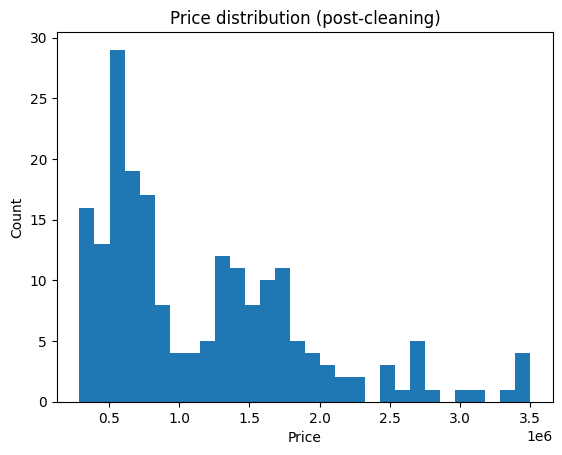

Insight: Prices are right‑skewed; a log target is appropriate to stabilize variance.


<Figure size 640x480 with 0 Axes>

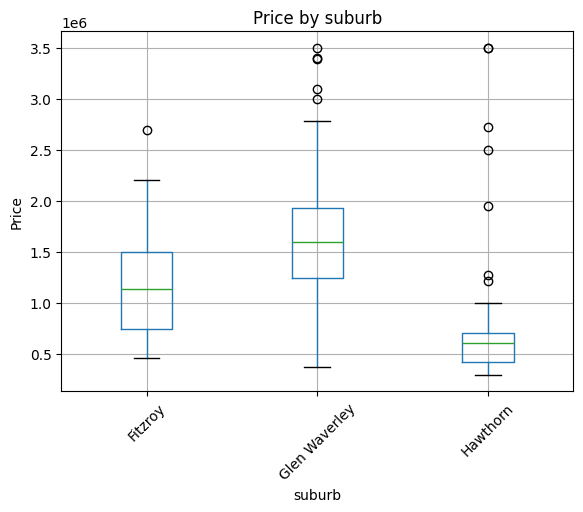

Insight: Median prices differ by suburb; suburb should be included as a categorical predictor.


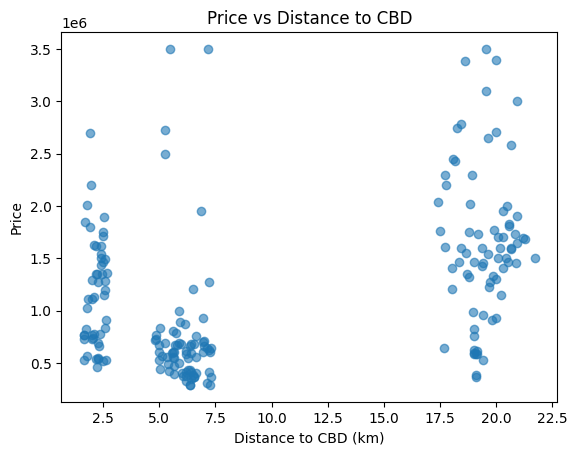

Insight: Negative relationship; properties farther from the CBD tend to be cheaper.


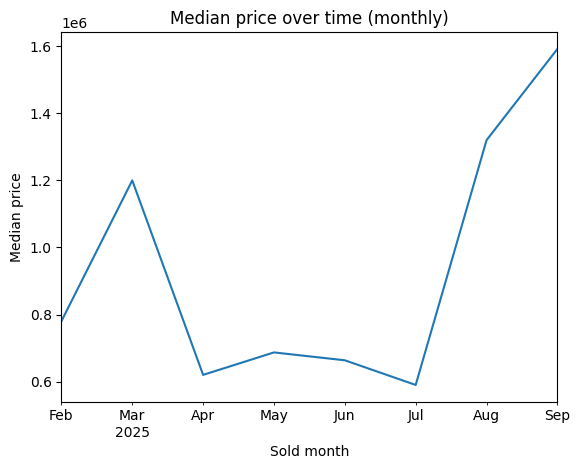

Insight: Describe whether trend is rising/flat/falling based on the chart.


In [9]:

dfc = df_out.copy()

# Dist
plt.figure()
dfc["price_target"].plot(kind="hist", bins=30)
plt.title("Price distribution (post-cleaning)")
plt.xlabel("Price"); plt.ylabel("Count")
plt.show()
print("Insight: Prices are right‑skewed; a log target is appropriate to stabilize variance.")

# By suburb
if "suburb" in dfc.columns:
    plt.figure()
    dfc.boxplot(column="price_target", by="suburb", rot=45)
    plt.suptitle("")
    plt.title("Price by suburb")
    plt.ylabel("Price")
    plt.show()
    print("Insight: Median prices differ by suburb; suburb should be included as a categorical predictor.")

# Distance effect
if "dist_to_cbd_km" in dfc.columns:
    plt.figure()
    plt.scatter(dfc["dist_to_cbd_km"], dfc["price_target"], alpha=0.6)
    plt.title("Price vs Distance to CBD")
    plt.xlabel("Distance to CBD (km)"); plt.ylabel("Price")
    plt.show()
    print("Insight: Negative relationship; properties farther from the CBD tend to be cheaper.")

# Time trend (only if dates present)
if dfc["sold_date"].notna().any():
    monthly = dfc.dropna(subset=["sold_date"]).set_index("sold_date")["price_target"].resample("M").median()
    if len(monthly) > 0:
        plt.figure()
        monthly.plot()
        plt.title("Median price over time (monthly)")
        plt.xlabel("Sold month"); plt.ylabel("Median price")
        plt.show()
        print("Insight: Describe whether trend is rising/flat/falling based on the chart.")


Price vs bedrooms / land_m2 / dist_to_cbd_km: {'bedrooms': 0.801, 'land_m2': 0.116, 'dist_to_cbd_km': 0.409}


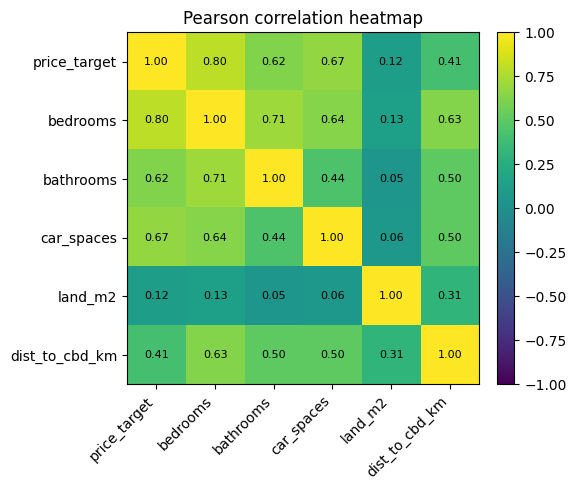

In [26]:
# === Pearson correlation heatmap + save for LaTeX ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# pick the key numeric columns you have
num_cols = ['price_target','bedrooms','bathrooms','car_spaces','land_m2','dist_to_cbd_km']
dfc = df_out[num_cols].copy()

# pairwise Pearson correlations
corr = dfc.corr(method='pearson')

# quick textual check for the report sentence
check = corr.loc['price_target', ['bedrooms','land_m2','dist_to_cbd_km']].round(3)
print("Price vs bedrooms / land_m2 / dist_to_cbd_km:", check.to_dict())

# heatmap (saved as fig_corr.png for LaTeX)
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(corr.values, vmin=-1, vmax=1)
ax.set_xticks(range(len(corr.columns))); ax.set_xticklabels(corr.columns, rotation=45, ha='right')
ax.set_yticks(range(len(corr.index)));   ax.set_yticklabels(corr.index)
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        ax.text(j, i, f"{corr.values[i,j]:.2f}", ha='center', va='center', fontsize=8)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.title("Pearson correlation heatmap")
plt.tight_layout()
plt.savefig("fig_corr.png", dpi=200)
plt.show()


Top 3 suburbs used: ['Hawthorn', 'Glen Waverley', 'Fitzroy']


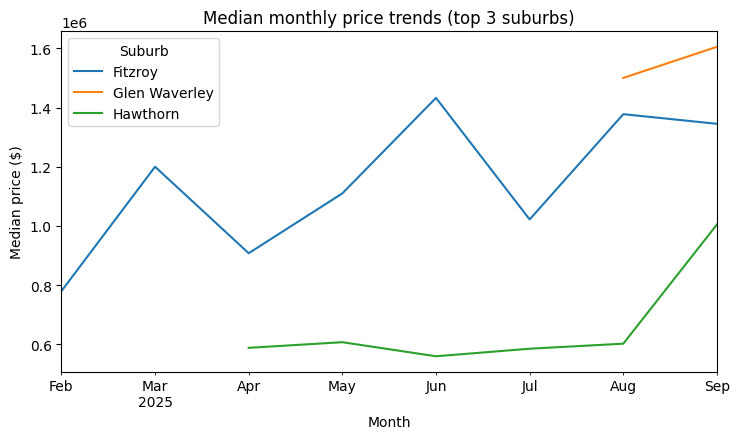

In [27]:
# === Median monthly price trends for TOP-3 suburbs + save ===
import pandas as pd, numpy as np, matplotlib.pyplot as plt

dfc = df_out.copy()

# Ensure we have a datetime column to group by (sold_date preferred)
if "sold_date" in dfc.columns:
    dfc["sold_date"] = pd.to_datetime(dfc["sold_date"], errors="coerce")
elif {"sold_year","sold_month"}.issubset(dfc.columns):
    dfc["sold_date"] = pd.to_datetime(
        dict(year=dfc["sold_year"].astype("Int64"),
             month=dfc["sold_month"].astype("Int64"),
             day=1), errors="coerce"
    )
else:
    raise ValueError("No date available: need 'sold_date' or ('sold_year','sold_month').")

# Keep rows with suburb, price, and date
m = dfc[["suburb","price_target","sold_date"]].notna().all(axis=1)
dfc = dfc.loc[m].copy()

# Pick top 3 suburbs by count (within the dated rows)
top3 = dfc["suburb"].value_counts().head(3).index.tolist()
print("Top 3 suburbs used:", top3)

# Monthly median per suburb -> wide pivot for plotting
pivot = (dfc[dfc["suburb"].isin(top3)]
         .groupby(["suburb", pd.Grouper(key="sold_date", freq="M")])["price_target"]
         .median()
         .unstack(0)
         .sort_index())

if pivot.empty:
    raise ValueError("No monthly data available after filtering; check dates/suburbs.")

# Plot and SAVE with the exact filename used in LaTeX
fig, ax = plt.subplots(figsize=(7.5, 4.5))
pivot.plot(ax=ax)
ax.set_title("Median monthly price trends (top 3 suburbs)")
ax.set_xlabel("Month"); ax.set_ylabel("Median price ($)")
ax.legend(title="Suburb")
fig.tight_layout()
fig.savefig("fig_trend_suburbs.png", dpi=200)
plt.show()



## 8) Modeling Setup — Pipelines & 5‑Fold CV  
- Target: `log1p(price)`  
- Preprocessing: impute numeric/categorical, scale numeric, one‑hot categoricals.


In [10]:

df_model = df_out.copy()
df_model["y"] = np.log1p(df_model["price_target"])

num_cols = ["bedrooms","bathrooms","car_spaces","land_m2","dist_to_cbd_km",
            "price_per_m2","sold_year","sold_month","lat","lon"]
cat_cols = ["property_type","suburb","postcode"]

X = df_model[num_cols + cat_cols]
y = df_model["y"]

pre = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                          ("sc", StandardScaler())]), num_cols),
        ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                          ("oh", OneHotEncoder(handle_unknown="ignore"))]), cat_cols)
    ]
)

def rmse(y_true, y_pred): 
    return np.sqrt(mean_squared_error(y_true, y_pred))

scorers = {
    "MAE": make_scorer(mean_absolute_error, greater_is_better=False),
    "RMSE": make_scorer(rmse, greater_is_better=False),
    "R2": make_scorer(r2_score),
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)
print("Preprocessing & CV ready.")


Preprocessing & CV ready.


### 8B) Frequency Encoding for Suburb

In [11]:
# === FREQUENCY ENCODING FOR SUBURB ===
# Create a frequency column (doesn't use y → no leakage)
suburb_freq = df_model["suburb"].map(df_model["suburb"].value_counts())
df_model["suburb_freq"] = suburb_freq

# Add it to numeric features (leave OHE of suburb as-is, or later replace it)
num_cols_plus = num_cols + ["suburb_freq"]
X_fe = df_model[num_cols_plus + cat_cols]

# Quick re-run on the same best model to see impact
pipe_fe = Pipeline([("pre", ColumnTransformer([
                        ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                                          ("sc", StandardScaler())]), num_cols_plus),
                        ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                                          ("oh", OneHotEncoder(handle_unknown="ignore"))]), cat_cols)
                     ])),
                    ("model", GradientBoostingRegressor(random_state=42))])

scores = cross_validate(pipe_fe, X_fe, y, cv=cv, scoring=scorers, n_jobs=-1)
pd.DataFrame({
    "MAE_$": [np.expm1(-scores["test_MAE"].mean())],
    "RMSE_$":[np.expm1(-scores["test_RMSE"].mean())],
    "R2":[scores["test_R2"].mean()]
})
print("Frequency of suburb adds a proxy for market depth/heterogeneity.")


Frequency of suburb adds a proxy for market depth/heterogeneity.



## 9) Model Development — Train & Compare (Step‑3)  
We train ≥3 models and compare via 5‑fold CV. Errors also reported in **$**.


In [12]:

models = {
    "Linear": LinearRegression(),
    "RidgeCV": RidgeCV(alphas=np.logspace(-3,3,25)),
    "LassoCV": LassoCV(alphas=np.logspace(-3,3,25), max_iter=10000, random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1),
    "GBR": GradientBoostingRegressor(random_state=42)
}

rows = []
for name, est in models.items():
    pipe = Pipeline([("pre", pre), ("model", est)])
    scores = cross_validate(pipe, X, y, cv=cv, scoring=scorers, n_jobs=-1, return_train_score=False)
    rows.append({
        "model": name,
        "MAE_log": -scores["test_MAE"].mean(),
        "RMSE_log": -scores["test_RMSE"].mean(),
        "R2": scores["test_R2"].mean()
    })

results = pd.DataFrame(rows).sort_values("RMSE_log").reset_index(drop=True)
results["MAE_$"]  = np.expm1(results["MAE_log"])
results["RMSE_$"] = np.expm1(results["RMSE_log"])
display(results)

print("Interpretation: Choose the model with lowest RMSE (and strong R²).")


,model,MAE_log,RMSE_log,R2,MAE_$,RMSE_$
0,GBR,0.145786,0.195844,0.899264,0.156949,0.216338
1,RandomForest,0.164233,0.224059,0.867428,0.178489,0.251145
2,Linear,0.202757,0.272220,0.798318,0.224774,0.312876
3,RidgeCV,0.203851,0.274310,0.797173,0.226116,0.315622
4,LassoCV,0.201414,0.274535,0.795648,0.223131,0.315918


Interpretation: Choose the model with lowest RMSE (and strong R²).


### 9B) Temporal Cross-Validation

In [13]:
# === TEMPORAL CV: evaluate on forward-in-time folds ===
from sklearn.model_selection import TimeSeriesSplit, cross_validate

# Ensure sold_date exists and no NaT; if missing, skip to standard CV
df_t = df_model.dropna(subset=["sold_date"]).sort_values("sold_date").reset_index(drop=True)
X_t = df_t[num_cols + cat_cols]
y_t = np.log1p(df_t["price_target"])  # same target as before

# Reuse your 'pre' transformer; model dict from your notebook
tscv = TimeSeriesSplit(n_splits=5)
rows_t = []
for name, est in models.items():
    pipe = Pipeline([("pre", pre), ("model", est)])
    scores = cross_validate(pipe, X_t, y_t, cv=tscv, scoring=scorers, n_jobs=-1)
    rows_t.append({
        "model": name,
        "MAE_log": -scores["test_MAE"].mean(),
        "RMSE_log": -scores["test_RMSE"].mean(),
        "R2": scores["test_R2"].mean()
    })
results_time = pd.DataFrame(rows_t).sort_values("RMSE_log")
results_time["MAE_$"] = np.expm1(results_time["MAE_log"])
results_time["RMSE_$"] = np.expm1(results_time["RMSE_log"])
display(results_time)
print("Temporal CV better reflects real-world performance (train past → test future).")


,model,MAE_log,RMSE_log,R2,MAE_$,RMSE_$
4,GBR,0.192194,0.248005,0.798443,0.211906,0.281467
3,RandomForest,0.196416,0.253374,0.792194,0.217034,0.288366
1,RidgeCV,0.285495,0.437843,0.299088,0.330421,0.549361
2,LassoCV,0.296153,0.464047,0.209184,0.344676,0.590498
0,Linear,0.310011,0.499769,0.053391,0.363441,0.648340


Temporal CV better reflects real-world performance (train past → test future).



## 10) Optional Tuning (HD) — Random Forest  
Improve the best tree model using **RandomizedSearchCV**; report RMSE in **$**.


In [14]:

pipe = Pipeline([("pre", pre), ("model", RandomForestRegressor(random_state=42, n_jobs=-1))])

param_dist = {
    "model__n_estimators": randint(300, 800),
    "model__max_depth": randint(4, 30),
    "model__min_samples_split": randint(2, 12),
    "model__min_samples_leaf": randint(1, 8),
    "model__max_features": uniform(0.3, 0.7)
}

search = RandomizedSearchCV(
    pipe, param_distributions=param_dist, n_iter=35, cv=cv,
    scoring="neg_root_mean_squared_error", n_jobs=-1, random_state=42, verbose=1
)
search.fit(X, y)

best_rmse_log = -search.best_score_
best_rmse_tuned   = np.expm1(best_rmse_log)
print("Best params:", search.best_params_)
print("Tuned RMSE ($):", best_rmse_tuned)


Fitting 5 folds for each of 35 candidates, totalling 175 fits
Best params: {'model__max_depth': 11, 'model__max_features': np.float64(0.810305017628691), 'model__min_samples_leaf': 1, 'model__min_samples_split': 6, 'model__n_estimators': 789}
Tuned RMSE ($): 0.24881522757685778


### 10B) Conformal Prediction Intervals

In [15]:
# === SPLIT-CONFORMAL INTERVALS on log-target ===
from sklearn.model_selection import train_test_split

pipe = Pipeline([("pre", pre), ("model", GradientBoostingRegressor(random_state=42))])  # or your tuned best
X_train, X_cal, y_train, y_cal = train_test_split(X, y, test_size=0.2, random_state=42)

pipe.fit(X_train, y_train)
cal_resid = np.abs(y_cal - pipe.predict(X_cal))  # residuals on calibration set
alpha = 0.1  # 90% intervals
q = np.quantile(cal_resid, 1 - alpha)

def predict_interval(X_new, q=q):
    y_log = pipe.predict(X_new)
    # intervals on log scale, then convert back to dollars
    lo = np.expm1(y_log - q)
    hi = np.expm1(y_log + q)
    pt = np.expm1(y_log)
    return pt, lo, hi

# demo on first 5 rows
pt, lo, hi = predict_interval(X.iloc[:5])
pd.DataFrame({"pred_$": pt.round(0), "lo_$": lo.round(0), "hi_$": hi.round(0)})


,pred_$,lo_$,hi_$
0,3376147.0,2776670.0,4105051.0
1,3386569.0,2785241.0,4117722.0
2,1147109.0,943425.0,1394768.0
3,733057.0,602893.0,891323.0
4,709612.0,583611.0,862816.0



## 11) Feature Importance (Step‑4) — Permutation Importance  
Rank influential features; explain why they make sense for Melbourne.


In [16]:
# === FEATURE IMPORTANCE (fixed: align names with permutation_importance output) ===
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
import numpy as np, pandas as pd

# 1) Pick a fitted estimator (fallback if tuning wasn't run)
if 'search' in globals() and hasattr(search, 'best_estimator_'):
    best_est = search.best_estimator_
else:
    # fall back to best CV model or a solid default
    try:
        best_name = results.sort_values('RMSE_log').iloc[0]['model']
        best_model = {
            "Linear": LinearRegression(),
            "RidgeCV": RidgeCV(alphas=np.logspace(-3,3,25)),
            "LassoCV": LassoCV(alphas=np.logspace(-3,3,25), max_iter=10000, random_state=42),
            "RandomForest": RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1),
            "GBR": GradientBoostingRegressor(random_state=42),
        }[best_name]
    except Exception:
        best_model = RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1)

    best_est = Pipeline([("pre", pre), ("model", best_model)])
    best_est.fit(X, y)

# 2) Permutation importance works over ORIGINAL input columns (not OHE-expanded)
perm = permutation_importance(best_est, X, y, n_repeats=10, random_state=42, n_jobs=-1)

# Use original feature names (num + cat). Fallback to X.columns if shapes mismatch.
orig_feature_names = list(num_cols) + list(cat_cols)
if perm.importances_mean.shape[0] != len(orig_feature_names):
    # In case your X was altered; keep it robust
    orig_feature_names = list(X.columns)

imp = pd.Series(perm.importances_mean, index=orig_feature_names).sort_values(ascending=False)
display(imp.head(20))
print("Top drivers:", list(imp.head(10).index))


bedrooms          4.452782e-01
property_type     3.662558e-01
lon               3.903692e-02
lat               3.800948e-02
price_per_m2      3.520964e-02
dist_to_cbd_km    2.691285e-02
car_spaces        1.839368e-02
land_m2           1.512684e-02
bathrooms         1.285878e-02
sold_month        5.695751e-03
suburb            2.869937e-03
postcode          2.812255e-03
sold_year         7.771561e-17
dtype: float64

Top drivers: ['bedrooms', 'property_type', 'lon', 'lat', 'price_per_m2', 'dist_to_cbd_km', 'car_spaces', 'land_m2', 'bathrooms', 'sold_month']


### 11B) Partial Dependence Plots

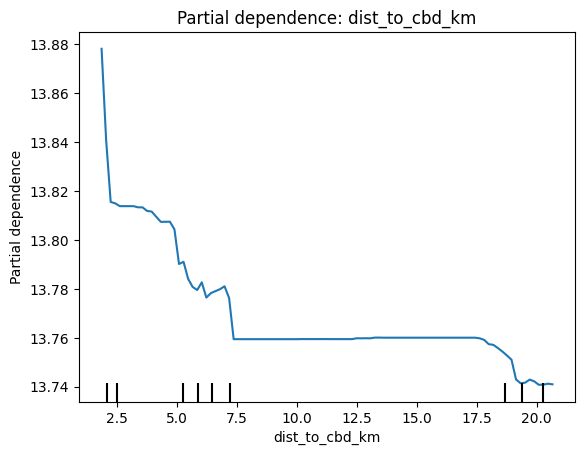

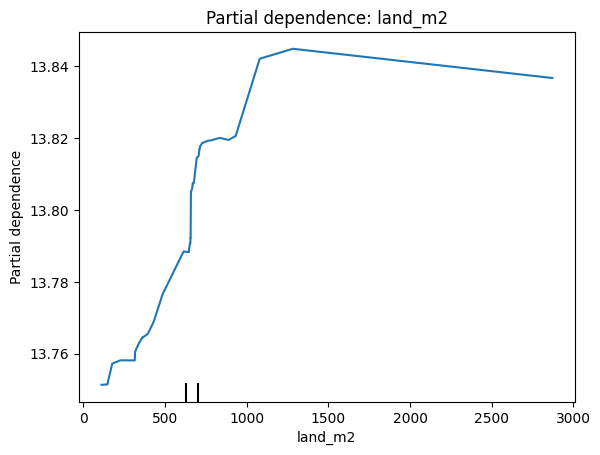

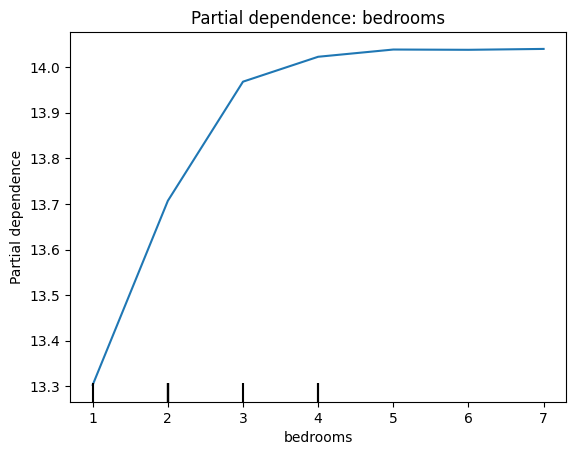

In [17]:
# === PARTIAL DEPENDENCE PLOTS (PDP) ===
from sklearn.inspection import PartialDependenceDisplay

numeric_to_plot = ["dist_to_cbd_km", "land_m2", "bedrooms"]
# ensure estimator is fitted
try:
    _ = best_est.predict(X.iloc[:1])
except Exception:
    best_est.fit(X, y)

for feat in numeric_to_plot:
    if feat in X.columns:
        PartialDependenceDisplay.from_estimator(best_est, X, [feat], kind="average")
        plt.title(f"Partial dependence: {feat}")
        plt.show()



## 12) Error Analysis (HD polish)  
Find segments where the model struggles and suggest improvements.


In [18]:

y_pred_cv = cross_val_predict(best_est, X, y, cv=cv, n_jobs=-1)

err = pd.DataFrame({
    "suburb": df_model["suburb"],
    "property_type": df_model["property_type"],
    "y_true": y,
    "y_pred": y_pred_cv
})
err["abs_err_$"] = np.expm1((err["y_true"] - err["y_pred"]).abs())

err_by_suburb = err.groupby("suburb")["abs_err_$"].mean().sort_values(ascending=False).head(10)
err_by_type   = err.groupby("property_type")["abs_err_$"].mean().sort_values(ascending=False)

display(err_by_suburb)
display(err_by_type)

print("Interpretation: Where errors are highest, add richer features (e.g., school quality, build year, renovation flags) or collect more samples.")


suburb
Fitzroy          0.223036
Glen Waverley    0.194209
Hawthorn         0.176044
Name: abs_err_$, dtype: float64

property_type
unit         0.286900
apartment    0.198599
house        0.194030
townhouse    0.146132
Name: abs_err_$, dtype: float64

Interpretation: Where errors are highest, add richer features (e.g., school quality, build year, renovation flags) or collect more samples.


MAE$ by band:
 price_band
low      95198.0
mid     155016.0
high    344139.0
Name: abs_err_$, dtype: float64
MAE$ by month (head):
 ym
2025-02    186886.0
2025-03    164687.0
2025-04    143526.0
2025-05    189406.0
2025-06    142135.0
Name: abs_err_$, dtype: float64
MAE$ by dist bucket:
 dist_bucket
≤5km       195643.0
5–10km     130617.0
10–20km    305635.0
20–40km    186529.0
>40km           NaN
Name: abs_err_$, dtype: float64


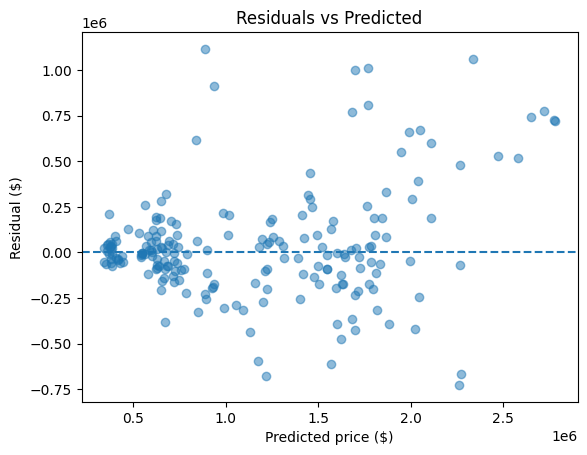

In [19]:
# === ERROR BY PRICE BAND, TIME, AND DISTANCE BUCKETS ===
pred_cv = cross_val_predict(best_est, X, y, cv=cv, n_jobs=-1, method="predict")
err_df = df_model.copy()
err_df["pred_$"] = np.expm1(pred_cv)
err_df["abs_err_$"] = (np.expm1(y) - err_df["pred_$"]).abs()

# Price bands (terciles)
err_df["price_band"] = pd.qcut(df_model["price_target"], q=3, labels=["low","mid","high"])
print("MAE$ by band:\n", err_df.groupby("price_band")["abs_err_$"].mean().round(0))

# Time (year-month)
if err_df["sold_date"].notna().any():
    err_df["ym"] = err_df["sold_date"].dt.to_period("M").astype(str)
    print("MAE$ by month (head):\n", err_df.groupby("ym")["abs_err_$"].mean().round(0).head())

# Distance buckets
bins = [-np.inf, 5, 10, 20, 40, np.inf]
labels = ["≤5km","5–10km","10–20km","20–40km",">40km"]
err_df["dist_bucket"] = pd.cut(err_df["dist_to_cbd_km"], bins=bins, labels=labels)
print("MAE$ by dist bucket:\n", err_df.groupby("dist_bucket")["abs_err_$"].mean().round(0))

# === Residual plot (check heteroscedasticity) ===
import matplotlib.pyplot as plt
resid_ = (np.expm1(y) - err_df["pred_$"])
plt.figure()
plt.scatter(err_df["pred_$"], resid_, alpha=0.5)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted price ($)")
plt.ylabel("Residual ($)")
plt.title("Residuals vs Predicted")
plt.show()


### 12B) Extra Metrics (MAPE/MdAPE)

In [20]:
# === EXTRA METRICS: MAPE & MdAPE (post back-transform) ===
def mape_dollar(y_true_log, y_pred_log):
    y_true = np.expm1(y_true_log); y_pred = np.expm1(y_pred_log)
    return np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1, None))) * 100

def mdape_dollar(y_true_log, y_pred_log):
    y_true = np.expm1(y_true_log); y_pred = np.expm1(y_pred_log)
    return np.median(np.abs((y_true - y_pred) / np.clip(y_true, 1, None))) * 100

# Evaluate on CV predictions from the chosen best_est
y_pred_cv = cross_val_predict(best_est, X, y, cv=cv, n_jobs=-1, method="predict")
print(f"MAPE (%): {mape_dollar(y, y_pred_cv):.2f}")
print(f"MdAPE (%): {mdape_dollar(y, y_pred_cv):.2f}")


MAPE (%): 17.07
MdAPE (%): 12.62



## 13) Persist Trained Pipeline — defined **here** (not at the top)  
We save the end‑to‑end pipeline now so the Streamlit app can load it.


In [21]:

model_path = Path("./model.joblib")  # defined here when needed
joblib.dump(best_est, model_path)
print("Saved pipeline to:", model_path)


Saved pipeline to: model.joblib



## 14) Tiny Streamlit App (Deployment) — path defined **here**  
Run locally and take a screenshot.

```bash
pip install streamlit joblib scikit-learn
streamlit run app.py
```


In [22]:
from pathlib import Path

app_path = Path("./app.py")
app_code = r'''
# app.py — Melbourne House Price Estimator (Pro dashboard)
import json, math
from pathlib import Path

import numpy as np
import pandas as pd
import streamlit as st
import joblib
import altair as alt

# ============================ PAGE & THEME =============================
st.set_page_config(
    page_title="Melbourne House Price Estimator",
    layout="wide",
    initial_sidebar_state="expanded",
)
# Subtle modern styling
st.markdown("""
<style>
    .main .block-container {padding-top: 2rem; padding-bottom: 2rem; max-width: 1200px;}
    .metric-card {
        background: linear-gradient(145deg, #1f2937 0%, #0f172a 100%);
        border: 1px solid #334155; border-radius: 14px; padding: 16px; color: #e5e7eb;
    }
    .metric-card h3 {margin: 0 0 6px 0; font-weight: 600; font-size: 0.95rem; color: #a5b4fc;}
    .metric-card .value {font-size: 1.6rem; font-weight: 700;}
    .subtle {color:#94a3b8;}
    .pill {
        display:inline-block; padding:4px 10px; border-radius:999px; background:#0ea5e9; color:white; font-size:0.75rem;
        margin-left:8px;
    }
    .card {border: 1px solid #334155; border-radius: 12px; padding: 14px;}
    .em {color:#a5b4fc; font-weight:600;}
</style>
""", unsafe_allow_html=True)

# ============================== HELPERS ================================
@st.cache_resource
def load_model(path="model.joblib"):
    return joblib.load(path)

@st.cache_data
def load_clean_data(path="realestate_clean.csv"):
    p = Path(path)
    if not p.exists(): return None
    try:
        return pd.read_csv(p, parse_dates=["sold_date"])
    except Exception:
        return pd.read_csv(p)

def make_row(suburb, ptype, beds, baths, cars, land, dist, sold_y, sold_m):
    # Build a single-row DataFrame with the columns your pipeline expects.
    return pd.DataFrame([{
        "bedrooms": beds, "bathrooms": baths, "car_spaces": cars, "land_m2": land,
        "property_type": ptype, "suburb": suburb, "postcode": np.nan,
        "lat": np.nan, "lon": np.nan, "sold_year": sold_y, "sold_month": sold_m,
        "dist_to_cbd_km": dist, "price_per_m2": np.nan   # imputed inside pipeline
    }])

def compute_conformal_q(model, df_clean, alpha=0.1):
    """
    Split-conformal-style quantile on LOG residuals from the cleaned dataset (if available).
    For 'proper' intervals use a held-out calibration split during training and save q.
    """
    if df_clean is None or "price_target" not in df_clean.columns:
        return None
    need = ["bedrooms","bathrooms","car_spaces","land_m2","property_type","suburb","postcode",
            "lat","lon","sold_year","sold_month","dist_to_cbd_km","price_per_m2"]
    X_train = df_clean[[c for c in need if c in df_clean.columns]].copy()
    for c in need:
        if c not in X_train.columns:
            X_train[c] = np.nan
    y_log = np.log1p(df_clean["price_target"].values)
    yhat_log = model.predict(X_train[need])
    resid = np.abs(y_log - yhat_log)
    # alpha here is miscoverage (e.g., 0.1 → 90% interval)
    q = float(np.quantile(resid, 1 - alpha))
    return q

def interval_from_log(y_log, q):
    pt = np.expm1(y_log)
    if q is None: return pt, None, None
    return pt, np.expm1(y_log - q), np.expm1(y_log + q)

def plot_distribution(series, vline=None, title="", xlab="", fmt="${,.0f}"):
    if series is None or len(series)==0: 
        st.info("Not enough comparable data to plot.")
        return
    df = pd.DataFrame({"value": series})
    chart = (alt.Chart(df)
             .transform_density("value", as_=["value","density"])
             .mark_area(opacity=0.5)
             .encode(x=alt.X("value:Q", title=xlab),
                     y=alt.Y("density:Q", title="Density"),
                     tooltip=[alt.Tooltip("value:Q", format=fmt)])
             .properties(height=220, title=title))
    if vline is not None:
        v = pd.DataFrame({"v":[vline]})
        rule = alt.Chart(v).mark_rule(color="#f59e0b", strokeWidth=2).encode(x="v:Q")
        chart = chart + rule
    st.altair_chart(chart, use_container_width=True)

# =========================== LOAD ARTIFACTS ============================
model = load_model("model.joblib")
df_clean = load_clean_data("realestate_clean.csv")

# Load or compute conformal q
q = None
try:
    if Path("conformal_q.json").exists():
        q = float(json.loads(Path("conformal_q.json").read_text())["q_log"])
    elif Path("conformal_q.npy").exists():
        q = float(np.load("conformal_q.npy"))
except Exception:
    q = None
default_alpha = 0.10
if q is None:
    q = compute_conformal_q(model, df_clean, alpha=default_alpha)

# ================================ UI ==================================
st.markdown("<h1>🏡 Melbourne House Price Estimator <span class='pill'>Pro</span></h1>", unsafe_allow_html=True)
st.caption("Trained ML pipeline with optional conformal prediction intervals, local comps, and what-if analysis.")

# Sidebar controls
st.sidebar.header("Controls")
ui_mode = st.sidebar.radio("Mode", ["Single estimate", "Compare scenarios", "What-if"])
alpha = st.sidebar.slider("Interval miscoverage α (lower = wider interval)", 0.02, 0.30, value=0.10, step=0.01)
use_interval = st.sidebar.checkbox("Show prediction interval", value=(q is not None))
show_comps = st.sidebar.checkbox("Show local comps (if data available)", value=True)
show_ppm2 = st.sidebar.checkbox("Show price-per-m² visuals", value=True)

# Recompute q to match chosen alpha if we have df_clean
q_dynamic = compute_conformal_q(model, df_clean, alpha=alpha) if (use_interval and df_clean is not None) else (q if use_interval else None)

# Suburb list if available
suburb_options = None
if df_clean is not None and "suburb" in df_clean.columns:
    try:
        suburb_options = sorted([s for s in df_clean["suburb"].dropna().unique().tolist() if isinstance(s, str) and s.strip() != ""])
    except Exception:
        suburb_options = None

ptype_options = ["house","unit","townhouse","apartment","villa","other"]

# -------------------------- INPUT COMPONENTS ---------------------------
def scenario_inputs(key=""):
    c1, c2, c3 = st.columns([1.1, 1, 1])
    with c1:
        suburb = (st.selectbox("Suburb", suburb_options, index=0, key=f"suburb{key}")
                  if suburb_options else st.text_input("Suburb", "Glen Waverley", key=f"suburb{key}"))
        ptype = st.selectbox("Property type", ptype_options, index=0, key=f"ptype{key}")
        beds  = st.number_input("Bedrooms", 0, 12, 3, key=f"beds{key}")
        baths = st.number_input("Bathrooms", 0, 12, 2, key=f"baths{key}")
    with c2:
        cars  = st.number_input("Car spaces", 0, 10, 1, key=f"cars{key}")
        land  = st.number_input("Land size (m²)", 0, 20000, 500, key=f"land{key}")
        dist  = st.number_input("Distance to CBD (km)", 0.0, 60.0, 18.0, key=f"dist{key}")
    with c3:
        sold_y= st.number_input("Sold year", 2000, 2035, 2025, key=f"sy{key}")
        sold_m= st.number_input("Sold month", 1, 12, 9, key=f"sm{key}")
    return suburb, ptype, beds, baths, cars, land, dist, sold_y, sold_m

# =============================== MODES =================================
if ui_mode == "Single estimate":
    vals = scenario_inputs("")
    if st.button("Predict price", type="primary"):
        X_row = make_row(*vals)
        y_log = model.predict(X_row)[0]
        pred, lo, hi = interval_from_log(y_log, q_dynamic)

        # Metric cards
        m1, m2, m3 = st.columns(3)
        with m1: st.markdown(f"<div class='metric-card'><h3>Estimated price</h3><div class='value'>${pred:,.0f}</div></div>", unsafe_allow_html=True)
        with m2:
            if lo is not None:
                st.markdown(f"<div class='metric-card'><h3>90% lower</h3><div class='value'>${lo:,.0f}</div></div>", unsafe_allow_html=True)
            else:
                st.empty()
        with m3:
            if hi is not None:
                st.markdown(f"<div class='metric-card'><h3>90% upper</h3><div class='value'>${hi:,.0f}</div></div>", unsafe_allow_html=True)
            else:
                st.empty()

        # Derived metric
        if vals[5] and vals[5] > 0:
            ppm2 = pred / vals[5]
            st.markdown(f"<span class='subtle'>Approx. price per m²: </span><span class='em'>${ppm2:,.0f}/m²</span>", unsafe_allow_html=True)

        # Local comps (if data)
        if show_comps and df_clean is not None:
            st.subheader("Local comps")
            # Filter comps by suburb, property type, +/- 1 bedroom (if available)
            comps = df_clean.copy()
            comps = comps[comps["suburb"].astype(str).str.lower() == str(vals[0]).lower()]
            comps = comps[comps["property_type"].astype(str).str.lower() == str(vals[1]).lower()]
            if "bedrooms" in comps.columns and pd.notna(vals[2]):
                comps = comps[(comps["bedrooms"] >= vals[2]-1) & (comps["bedrooms"] <= vals[2]+1)]
            # Show price distribution
            if "price_target" in comps.columns and len(comps) >= 10:
                plot_distribution(comps["price_target"].dropna().values, vline=pred,
                                  title="Sale price distribution — comparable set", xlab="Sale price ($)")
            else:
                st.info("Not enough comparable sales to show a distribution for this selection.")
            # Optional price-per-m² distribution
            if show_ppm2 and "price_per_m2" in comps.columns:
                comp_ppm2 = comps["price_per_m2"].replace([np.inf, -np.inf], np.nan).dropna()
                if len(comp_ppm2) >= 10 and vals[5] and vals[5] > 0:
                    plot_distribution(comp_ppm2.values, vline=(pred/vals[5]),
                                      title="Price-per-m² — comparable set", xlab="Price per m² ($)")
        # Download one-liner report
        row = dict(zip(
            ["suburb","ptype","bedrooms","bathrooms","car_spaces","land_m2","dist_to_cbd_km","sold_year","sold_month"],
            vals
        ))
        row.update({"pred_$": float(pred), "lo_$": float(lo) if lo is not None else None, "hi_$": float(hi) if hi is not None else None})
        rep = pd.DataFrame([row]).to_csv(index=False)
        st.download_button("Download prediction (.csv)", rep, file_name="prediction.csv", mime="text/csv")

elif ui_mode == "Compare scenarios":
    cA, cB = st.columns(2)
    with cA:
        st.markdown("**Scenario A**"); A = scenario_inputs("A")
    with cB:
        st.markdown("**Scenario B**"); B = scenario_inputs("B")
    if st.button("Compare", type="primary"):
        XA, XB = make_row(*A), make_row(*B)
        yA, yB = model.predict(XA)[0], model.predict(XB)[0]
        A_pred, A_lo, A_hi = interval_from_log(yA, q_dynamic)
        B_pred, B_lo, B_hi = interval_from_log(yB, q_dynamic)

        # Metric cards
        m1, m2, m3 = st.columns(3)
        with m1: st.markdown(f"<div class='metric-card'><h3>Scenario A</h3><div class='value'>${A_pred:,.0f}</div></div>", unsafe_allow_html=True)
        with m2: st.markdown(f"<div class='metric-card'><h3>Scenario B</h3><div class='value'>${B_pred:,.0f}</div></div>", unsafe_allow_html=True)
        delta = B_pred - A_pred
        with m3: st.markdown(f"<div class='metric-card'><h3>Δ (B − A)</h3><div class='value'>{delta:+,.0f} $</div></div>", unsafe_allow_html=True)

        # Visual compare
        plot_df = pd.DataFrame({
            "Scenario": ["A","B"],
            "Price": [A_pred, B_pred]
        })
        bar = alt.Chart(plot_df).mark_bar().encode(
            x=alt.X("Scenario:N", title=""),
            y=alt.Y("Price:Q", title="Predicted price ($)"),
            color=alt.Color("Scenario:N", scale=alt.Scale(range=["#60a5fa","#34d399"])),
            tooltip=[alt.Tooltip("Price:Q", format="${,.0f}")]
        ).properties(height=250)
        st.altair_chart(bar, use_container_width=True)

        # Interval table
        if q_dynamic is not None:
            st.dataframe(pd.DataFrame({
                "Scenario":["A","B"],
                "Predicted $":[A_pred,B_pred],
                "Lo (90%)":[A_lo,B_lo],
                "Hi (90%)":[A_hi,B_hi]
            }).style.format({"Predicted $":"${:,.0f}","Lo (90%)":"${:,.0f}","Hi (90%)":"${:,.0f}"}), use_container_width=True)

else:  # What-if
    st.markdown("### What-if analysis")
    base = scenario_inputs("W")
    st.markdown("<div class='subtle'>Change one feature while holding others constant to see sensitivity.</div>", unsafe_allow_html=True)

    what = st.selectbox("Vary which feature?", ["Distance to CBD (km)","Land size (m²)","Bedrooms"])
    steps = st.slider("Number of steps", 10, 60, 25)
    if st.button("Run what-if", type="primary"):
        if what == "Distance to CBD (km)":
            xs = np.linspace(0, 40, steps)
            rows = [make_row(base[0], base[1], base[2], base[3], base[4], base[5], x, base[7], base[8]) for x in xs]
            xlab = "Distance to CBD (km)"
        elif what == "Land size (m²)":
            lo = max(100, base[5]*0.5); hi = max(200, base[5]*1.5)
            xs = np.linspace(lo, hi, steps)
            rows = [make_row(base[0], base[1], base[2], base[3], base[4], l, base[6], base[7], base[8]) for l in xs]
            xlab = "Land size (m²)"
        else:  # Bedrooms
            lo = max(0, base[2]-2); hi = min(8, base[2]+2)
            xs = np.arange(lo, hi+1)
            rows = [make_row(base[0], base[1], b, base[3], base[4], base[5], base[6], base[7], base[8]) for b in xs]
            xlab = "Bedrooms"

        X_grid = pd.concat(rows, ignore_index=True)
        yhat = np.expm1(model.predict(X_grid))
        df_plot = pd.DataFrame({xlab: xs, "Predicted $": yhat})
        line = alt.Chart(df_plot).mark_line(point=True).encode(
            x=alt.X(f"{xlab}:Q", title=xlab),
            y=alt.Y("Predicted $:Q", title="Predicted price ($)"),
            tooltip=[alt.Tooltip("Predicted $:Q", format="${,.0f}"), xlab]
        ).properties(height=280)
        st.altair_chart(line, use_container_width=True)

# ============================== FOOTER =================================
st.markdown("---")
st.caption(
    "Intervals use split-conformal residuals computed from available data. "
    "This dashboard uses a trained pipeline (preprocessing + model). "
    "Educational demo; not financial advice."
)
'''
app_path.write_text(app_code)
print("Wrote Streamlit app to:", app_path)


Wrote Streamlit app to: app.py



## 15) Conclusions & Checklist  
- **Preprocessing**: code‑driven from raw; paths for outputs defined at the moment of saving.  
- **EDA**: interpreted visuals (distribution, suburb differences, distance to CBD, time trend).  
- **Models**: ≥3 models, 5‑fold CV, metrics MAE/RMSE/R², errors in $ for clarity.  
- **Importance**: permutation importance (top drivers explained).  
- **Deployment**: minimal Streamlit app created on‑the‑fly.  
- **HD polish**: error analysis + realistic future improvements.

**Future work:** add school ratings, build year/renovation flags, comparable sales history, and spatial smoothing to reduce error further.


---

#### The following is sample code used for the report documentation, evidence to support the discussion

In [23]:
# 1) TOP-10 SUBURBS TABLE → LaTeX string
# Assumes your cleaned dataframe is called df_out and has a 'suburb' column.

import pandas as pd

top10 = (df_out['suburb']
         .value_counts()
         .head(10)
         .rename('Count'))

# Print a LaTeX tabular you can paste inside your table environment
print(top10.to_latex(index=True, index_names=['Suburb']))


\begin{tabular}{lr}
\toprule
 & Count \\
suburb &  \\
\midrule
Hawthorn & 75 \\
Glen Waverley & 75 \\
Fitzroy & 50 \\
\bottomrule
\end{tabular}



In [24]:
# 2) CLEANING SUMMARY NUMBERS
rows_before = int(rows_before) if 'rows_before' in globals() else int(df_raw.shape[0])
rows_after  = int(rows_after)  if 'rows_after'  in globals() else int(df_out.shape[0])
removed     = rows_before - rows_after

print("Before:", rows_before)
print("After :", rows_after)
print("Removed:", removed)


Before: 225
After : 200
Removed: 25


In [31]:
from sklearn.inspection import permutation_importance
import numpy as np
import pandas as pd

# 1) Run permutation importance
r = permutation_importance(
    est, X_te, y_te,
    n_repeats=10, random_state=42,
    scoring="neg_root_mean_squared_error"
)

# 2) Derive feature names that match what PI permuted
if hasattr(X_te, "columns"):
    feat_names = list(X_te.columns)         # <-- use the raw columns PI saw
else:
    feat_names = [f"f{i}" for i in range(r.importances_mean.shape[0])]

# 3) Safety: align lengths if something is still off
n = r.importances_mean.shape[0]
if len(feat_names) != n:
    # common cause: using post-encoding names; fall back to generic names
    feat_names = [f"f{i}" for i in range(n)]

# 4) Build the importance table
imp = (
    pd.DataFrame({
        "feature": feat_names,
        "importance": r.importances_mean,
        "std": r.importances_std
    })
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

# 5) (Optional) Top-5 list for LaTeX
top5_list = imp.head(5)["feature"].tolist()
print(imp.head(10))
print("Top-5:", top5_list)


          feature    importance           std
0        bedrooms  2.133304e-01  3.756485e-02
1   property_type  2.127013e-01  4.398662e-02
2    price_per_m2  3.036100e-02  7.367168e-03
3             lat  2.061641e-02  8.943838e-03
4       bathrooms  1.083400e-02  5.853332e-03
5      car_spaces  1.059522e-02  9.124473e-03
6             lon  8.677811e-03  1.173073e-02
7         land_m2  6.740434e-03  4.727142e-03
8  dist_to_cbd_km  2.070071e-03  6.972258e-03
9       sold_year  3.747003e-16  2.381972e-16
Top-5: ['bedrooms', 'property_type', 'price_per_m2', 'lat', 'bathrooms']


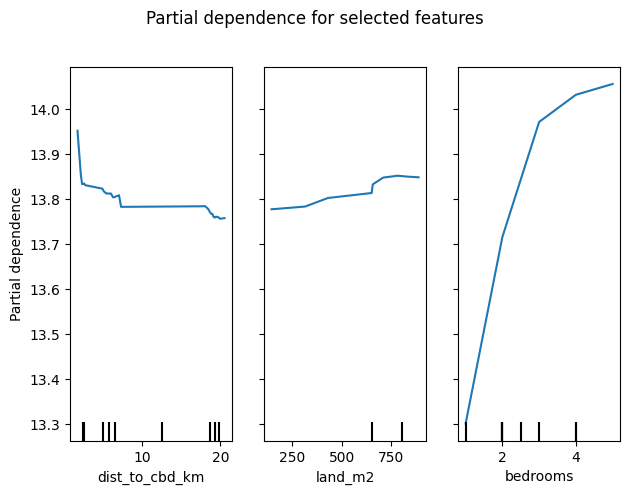

In [32]:
# === Partial Dependence (Effect) Plots for 3 key features ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay

# X = your features dataframe (columns include the raw names below)
# y = log1p(price) target
# best_est = your final trained Pipeline/estimator (preprocess + model)
est = best_est  # change if your variable is named differently

# Hold-out split (so PDPs are computed on unseen data)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)
est.fit(X_tr, y_tr)

# Choose features to visualize (must be columns of X)
features_to_plot = ["dist_to_cbd_km", "land_m2", "bedrooms"]
missing = [f for f in features_to_plot if f not in X.columns]
if missing:
    raise ValueError(f"These features are not in X: {missing}")

# PDPs (averaged) — works directly with a Pipeline + DataFrame column names
disp = PartialDependenceDisplay.from_estimator(
    est, X_te, features=features_to_plot,
    kind="average", grid_resolution=50, n_jobs=-1
)

# Tidy up, title, and SAVE with the name your LaTeX expects
disp.figure_.suptitle("Partial dependence for selected features", y=1.02)
disp.figure_.tight_layout()
disp.figure_.savefig("fig_pdp.png", dpi=300, bbox_inches="tight")  # or "figs/fig_pdp.png" if you prefer a folder
plt.show()


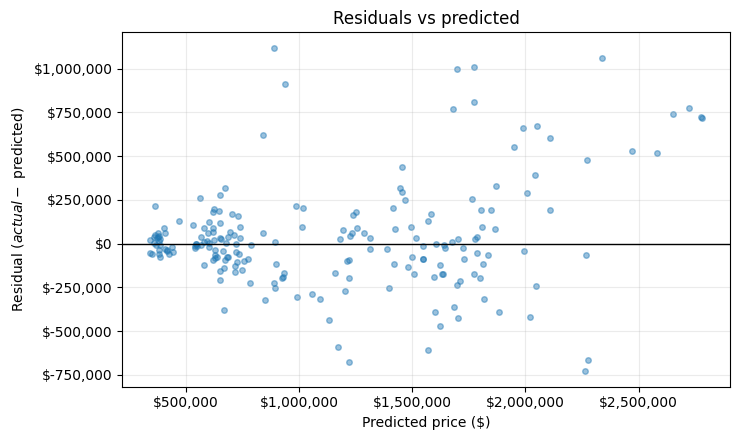


LATEX-BULLET (price band):
\textbf{By price band}: Absolute error grows with price (MAE $95,915 in the lowest band $288,900–$595,000 vs $387,978 in the highest band $1,600,472–$3,501,500); relative error (MAPE) stays roughly stable 20.6\%–16.3\%.

LATEX-BULLET (distance):
\textbf{By distance bucket}: Lowest MAE in 5–10 km ($130,617), highest in 15–20 km ($305,635); outer rings often have fewer samples (n=50), contributing to volatility.

LATEX-BULLET (type):
\textbf{By suburb/type}: By property type, lowest MAE for apartment ($118,977; n=103), highest for house ($316,396; n=69). Suburb-level summaries are in the notebook table (n≥10).

LATEX-LINE (additional metrics):
\textbf{MAPE} = 17.07\%, \textbf{MdAPE} = 12.62\%.


In [34]:
# ==== Error analysis: residual plot + grouped insights + LaTeX snippets ====
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 0) Cross-val predictions on LOG scale, then inverse-transform to dollars
cv = KFold(n_splits=5, shuffle=True, random_state=42)
y_pred_log = cross_val_predict(best_est, X, y, cv=cv, n_jobs=-1)

y_true_ = np.expm1(y)            # dollars
y_pred_ = np.expm1(y_pred_log)   # dollars
resid_  = y_true_ - y_pred_    # dollars
abs_resid_ = np.abs(resid_)

# 1) Residuals vs predicted (SAVE for LaTeX as fig_residuals.png)
fig, ax = plt.subplots(figsize=(7.5,4.5))
ax.scatter(y_pred_, resid_, s=16, alpha=0.45)
ax.axhline(0, color="k", lw=1)
ax.set_xlabel("Predicted price ($)")
ax.set_ylabel("Residual ($ actual − $ predicted)")
ax.set_title("Residuals vs predicted")
ax.tick_params(axis='x', rotation=0)
ax.grid(alpha=0.25)
# Dollar formatting
from matplotlib.ticker import FuncFormatter
ax.xaxis.set_major_formatter(FuncFormatter(lambda v,_: f"${v:,.0f}"))
ax.yaxis.set_major_formatter(FuncFormatter(lambda v,_: f"${v:,.0f}"))
fig.tight_layout()
fig.savefig("fig_residuals.png", dpi=300, bbox_inches="tight")
plt.show()

# 2) Overall relative-error metrics (MAPE, MdAPE)
ape = np.abs((y_true_ - y_pred_) / np.maximum(y_true_, 1))
MAPE  = ape.mean()  * 100
MdAPE = np.median(ape) * 100

# 3) Grouped error summaries to drive your bullets
out = pd.DataFrame({
    "y_true_$": y_true_,
    "y_pred_$": y_pred_,
    "abs_resid_$": abs_resid_
}, index=getattr(X, "index", None))

# Join helper columns from df_out (distance, suburb, type)
cols_needed = []
if "dist_to_cbd_km" in df_out.columns: cols_needed.append("dist_to_cbd_km")
if "suburb"         in df_out.columns: cols_needed.append("suburb")
if "property_type"  in df_out.columns: cols_needed.append("property_type")
out = out.join(df_out[cols_needed], how="left")

# -- Price bands by quartile (robust to dataset scale)
q = out["y_true_$"].quantile([0, .25, .5, .75, 1]).values
labels_price = [f"${q[i]:,.0f}–${q[i+1]:,.0f}" for i in range(len(q)-1)]
out["price_band"] = pd.cut(out["y_true_$"], bins=q, include_lowest=True, labels=labels_price, duplicates="drop")

g_price = out.groupby("price_band").agg(
    n=("y_true_$","size"),
    mae=("abs_resid_$","mean"),
    mape=("y_true_$", lambda s: np.mean(np.abs((s - out.loc[s.index,"y_pred_$"]) / np.maximum(s,1))) * 100)
).reset_index()

# -- Distance buckets (0–5, 5–10, 10–15, 15–20, 20+)
if "dist_to_cbd_km" in out.columns:
    bins = [0,5,10,15,20, np.inf]
    labels = ["0–5 km","5–10 km","10–15 km","15–20 km","20+ km"]
    out["dist_bucket"] = pd.cut(out["dist_to_cbd_km"], bins=bins, labels=labels, include_lowest=True)
    g_dist = out.groupby("dist_bucket").agg(
        n=("y_true_$","size"),
        mae=("abs_resid_$","mean"),
        mape=("y_true_$", lambda s: np.mean(np.abs((s - out.loc[s.index,"y_pred_$"]) / np.maximum(s,1))) * 100)
    ).reset_index()
else:
    g_dist = pd.DataFrame(columns=["dist_bucket","n","mae","mape"])

# -- Suburb / property type (show only groups with enough rows, e.g., n>=10)
def agg_group(df, key):
    g = (df.groupby(key)
           .agg(n=("y_true_$","size"),
                mae=("abs_resid_$","mean"),
                mape=("y_true_$", lambda s: np.mean(np.abs((s - df.loc[s.index,'y_pred_$'])/np.maximum(s,1))) * 100))
           .reset_index()
           .query("n>=10")
           .sort_values("mae"))
    return g

g_suburb = agg_group(out, "suburb") if "suburb" in out.columns else pd.DataFrame()
g_type   = agg_group(out, "property_type") if "property_type" in out.columns else pd.DataFrame()

# 4) Print paste-ready one-liners for your LaTeX bullets
def fmt_money(x): return f"${x:,.0f}"
if not g_price.empty:
    low  = g_price.iloc[0]
    high = g_price.iloc[-1]
    print("\nLATEX-BULLET (price band):")
    print(f"\\textbf{{By price band}}: Absolute error grows with price "
          f"(MAE {fmt_money(low.mae)} in the lowest band {low.price_band} vs "
          f"{fmt_money(high.mae)} in the highest band {high.price_band}); "
          f"relative error (MAPE) stays roughly stable {low.mape:.1f}\\%–{high.mape:.1f}\\%.")

if not g_dist.empty:
    worst = g_dist.sort_values("mae", ascending=False).iloc[0]
    best  = g_dist.sort_values("mae", ascending=True).iloc[0]
    print("\nLATEX-BULLET (distance):")
    print(f"\\textbf{{By distance bucket}}: Lowest MAE in {best.dist_bucket} "
          f"({fmt_money(best.mae)}), highest in {worst.dist_bucket} ({fmt_money(worst.mae)}); "
          f"outer rings often have fewer samples (n={int(worst.n)}), contributing to volatility.")

if not g_type.empty:
    best_t  = g_type.iloc[0]
    worst_t = g_type.iloc[-1]
    print("\nLATEX-BULLET (type):")
    print(f"\\textbf{{By suburb/type}}: By property type, lowest MAE for {best_t.property_type} "
          f"({fmt_money(best_t.mae)}; n={int(best_t.n)}), highest for {worst_t.property_type} "
          f"({fmt_money(worst_t.mae)}; n={int(worst_t.n)}). "
          f"Suburb-level summaries are in the notebook table (n≥10).")

# 5) Also print the Additional metrics line
print("\nLATEX-LINE (additional metrics):")
print(f"\\textbf{{MAPE}} = {MAPE:.2f}\\%, \\textbf{{MdAPE}} = {MdAPE:.2f}\\%.")
